#### Using LightGCN for Learning Recommendations

Note that this is using the explicit ratings because I think the continuous values might be more informative for a GNN to learn latent properties

In [613]:
RATINGS_CSV = "./data/full-dataset/ml-explicit/ratings.csv"
MOVIES_CSV = "./data/full-dataset/ml-explicit/movies.csv"

In [614]:
import pandas as pd

ratings_df = pd.read_csv("./data/full-dataset/ml-explicit/ratings.csv")
movies_df = pd.read_csv("./data/full-dataset/ml-explicit/movies.csv")

In [615]:
# Merge the dataframes on 'movieId' column
full_ratings_df = pd.merge(ratings_df, movies_df[['movieId', 'title']], on='movieId', how='left')
# Rename the columns
full_ratings_df = full_ratings_df.rename(columns={'title': 'movieName'})
# Reorder the columns --> this is going to let me get movie information later
full_ratings_df = full_ratings_df[['userId', 'movieId', 'movieName', 'rating', 'timestamp']]

In [608]:
full_ratings_df.head(5)

,userId,movieId,movieName,rating,timestamp
0,1,17,Sense and Sensibility,4.0,944249077
1,1,25,Leaving Las Vegas,1.0,944250228
2,1,29,"City of Lost Children, The",2.0,943230976
3,1,30,Shanghai Triad,5.0,944249077
4,1,32,Twelve Monkeys,5.0,943228858


In [616]:
IDS_TO_MOVIES = dict(zip(movies_df['movieId'], movies_df['title']))
len(IDS_TO_MOVIES.keys())

31271

Creating data structures for the different node types:

In [6]:
""" 
  Defining classes to use in the graph. 
  Attempting to build a bipartite graph where the two node types are users and movies. 
"""

movies = []

class Movie:
  """
  Class for a movie, which contains:
    1. ID (unique to Movielens dataset)
    2. Name (the name of the movie)
  """

  def __init__(self, movielens_id):
    self.movielens_id = int(movielens_id)
    self.name = f"movie_{self.movielens_id}"
    self.title = str(IDS_TO_MOVIES[movielens_id])

  def __str__(self):
    return f"Movie {self.movielens_id}: {self.title}"

  def __repr__(self):
    return self.name

In [283]:
class User:
  """
  Class for a user, which contains:
    1. ID (user id on the movielens platform)
    2. Ratings (dictionary of movies rated and their ratings)
  """

  def __init__(self, user_id, ratings):
    self.id = int(user_id)
    self.name = f"user_{user_id}"
    self.ratings = {f"movie_{key}": value/5 for key,value in ratings.items()}

  def __str__(self):
    return f"User: {self.name}"

  def __repr__(self):
    return f"{self.name}"

In [390]:
from tqdm import tqdm

In [617]:
users = []

grouped_df = full_ratings_df.groupby('userId')

# this is basically allowing me to control how many users I am constructing the graph for.
count = 0

for userID, group_df in tqdm(grouped_df, total=len(grouped_df), desc="Processing Users"):
    if count >= 20000 and userID != 200952: #getting the first 10,000 users plus my user
        continue
    elif userID%10 != 0 and userID != 200952:
        continue
    # if userID <= 178745: #getting the last 20,000 users plus my user
    #     continue
    ratings_dict = dict(zip(group_df['movieId'], group_df['rating']))
    user = User(userID, ratings_dict)
    users.append(user)
    count += 1


Processing Users: 100%|██████████| 200712/200712 [00:08<00:00, 22678.20it/s]


In [618]:
len(users)

20001

In [543]:
# check to make sure the user-movie creation worked correctly
users

[user_178746,
 user_178747,
 user_178748,
 user_178749,
 user_178750,
 user_178751,
 user_178752,
 user_178753,
 user_178754,
 user_178755,
 user_178756,
 user_178757,
 user_178758,
 user_178759,
 user_178760,
 user_178761,
 user_178762,
 user_178763,
 user_178764,
 user_178765,
 user_178766,
 user_178767,
 user_178768,
 user_178769,
 user_178770,
 user_178771,
 user_178772,
 user_178773,
 user_178774,
 user_178775,
 user_178776,
 user_178777,
 user_178778,
 user_178779,
 user_178780,
 user_178781,
 user_178782,
 user_178783,
 user_178784,
 user_178785,
 user_178786,
 user_178787,
 user_178788,
 user_178789,
 user_178790,
 user_178791,
 user_178792,
 user_178793,
 user_178794,
 user_178795,
 user_178796,
 user_178797,
 user_178798,
 user_178799,
 user_178800,
 user_178801,
 user_178802,
 user_178803,
 user_178804,
 user_178805,
 user_178806,
 user_178807,
 user_178808,
 user_178809,
 user_178810,
 user_178811,
 user_178812,
 user_178813,
 user_178814,
 user_178815,
 user_178816,
 user_

In [611]:
# we have a list of users, now we just need a list of all the unique movies
movies = [Movie(x) for x in IDS_TO_MOVIES.keys()] 

In [13]:
type(movies[0])

__main__.Movie

Building graphs:

In [619]:
import networkx as nx

MovielensGraph = nx.Graph()
MovielensGraph.add_nodes_from([
    (u.name, {'name':u.name, "node_type" : "user"}) for u in users
])
MovielensGraph.add_nodes_from([
    (m.name, {'name':m.name, "node_type" : "movies"}) for m in movies
])

edge_list = []
for user in users:
  for movie in user.ratings.keys():
    edge_list.append((user.name, movie))
MovielensGraph.add_edges_from(edge_list)

In [620]:
print('Num nodes:', MovielensGraph.number_of_nodes(), '. Num edges:', MovielensGraph.number_of_edges())

Num nodes: 51272 . Num edges: 3128042


In [622]:
# reduce the graph into a smaller subgraph for handling directly on the PC
kcore = 30
MovielensGraph = nx.k_core(MovielensGraph, kcore)
print('Num nodes:', MovielensGraph.number_of_nodes(), '. Num edges:', MovielensGraph.number_of_edges())

Num nodes: 24166 . Num edges: 2916980


In [464]:
nx.get_node_attributes(MovielensGraph, 'name')

{'user_39410': 'user_39410',
 'user_37485': 'user_37485',
 'user_75710': 'user_75710',
 'user_19485': 'user_19485',
 'user_23120': 'user_23120',
 'user_91715': 'user_91715',
 'user_37575': 'user_37575',
 'movie_1050': 'movie_1050',
 'movie_2353': 'movie_2353',
 'movie_1479': 'movie_1479',
 'movie_1821': 'movie_1821',
 'user_43300': 'user_43300',
 'user_56995': 'user_56995',
 'user_66905': 'user_66905',
 'user_22750': 'user_22750',
 'user_100155': 'user_100155',
 'movie_2641': 'movie_2641',
 'user_54450': 'user_54450',
 'user_60290': 'user_60290',
 'movie_60753': 'movie_60753',
 'movie_3334': 'movie_3334',
 'user_83900': 'user_83900',
 'movie_134130': 'movie_134130',
 'user_68720': 'user_68720',
 'user_65915': 'user_65915',
 'user_89475': 'user_89475',
 'movie_3316': 'movie_3316',
 'user_61130': 'user_61130',
 'user_13880': 'user_13880',
 'user_22930': 'user_22930',
 'user_70330': 'user_70330',
 'user_52685': 'user_52685',
 'user_11920': 'user_11920',
 'user_81820': 'user_81820',
 'movi

In [623]:
if "user_200952" in nx.get_node_attributes(MovielensGraph, 'name').keys():
    print("yes") # making sure that my user is in the graph

yes


------- stuff for plotting visuals of the graph -------
Credit to plotting section goes to https://medium.com/stanford-cs224w/spotify-track-neural-recommender-system-51d266e31e16 

In [648]:
import random
# Make a large subgraph
random.seed(500)
rand_nodes_lg = random.sample(list(MovielensGraph.nodes()), 2000)
sub_G_lg = MovielensGraph.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())
# Make a smaller subgraph from the larger one
rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)
sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)
largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)
sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))
print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),
      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1970 . Num edges: 18667
Small subgraph Num nodes: 301 . Num edges: 691


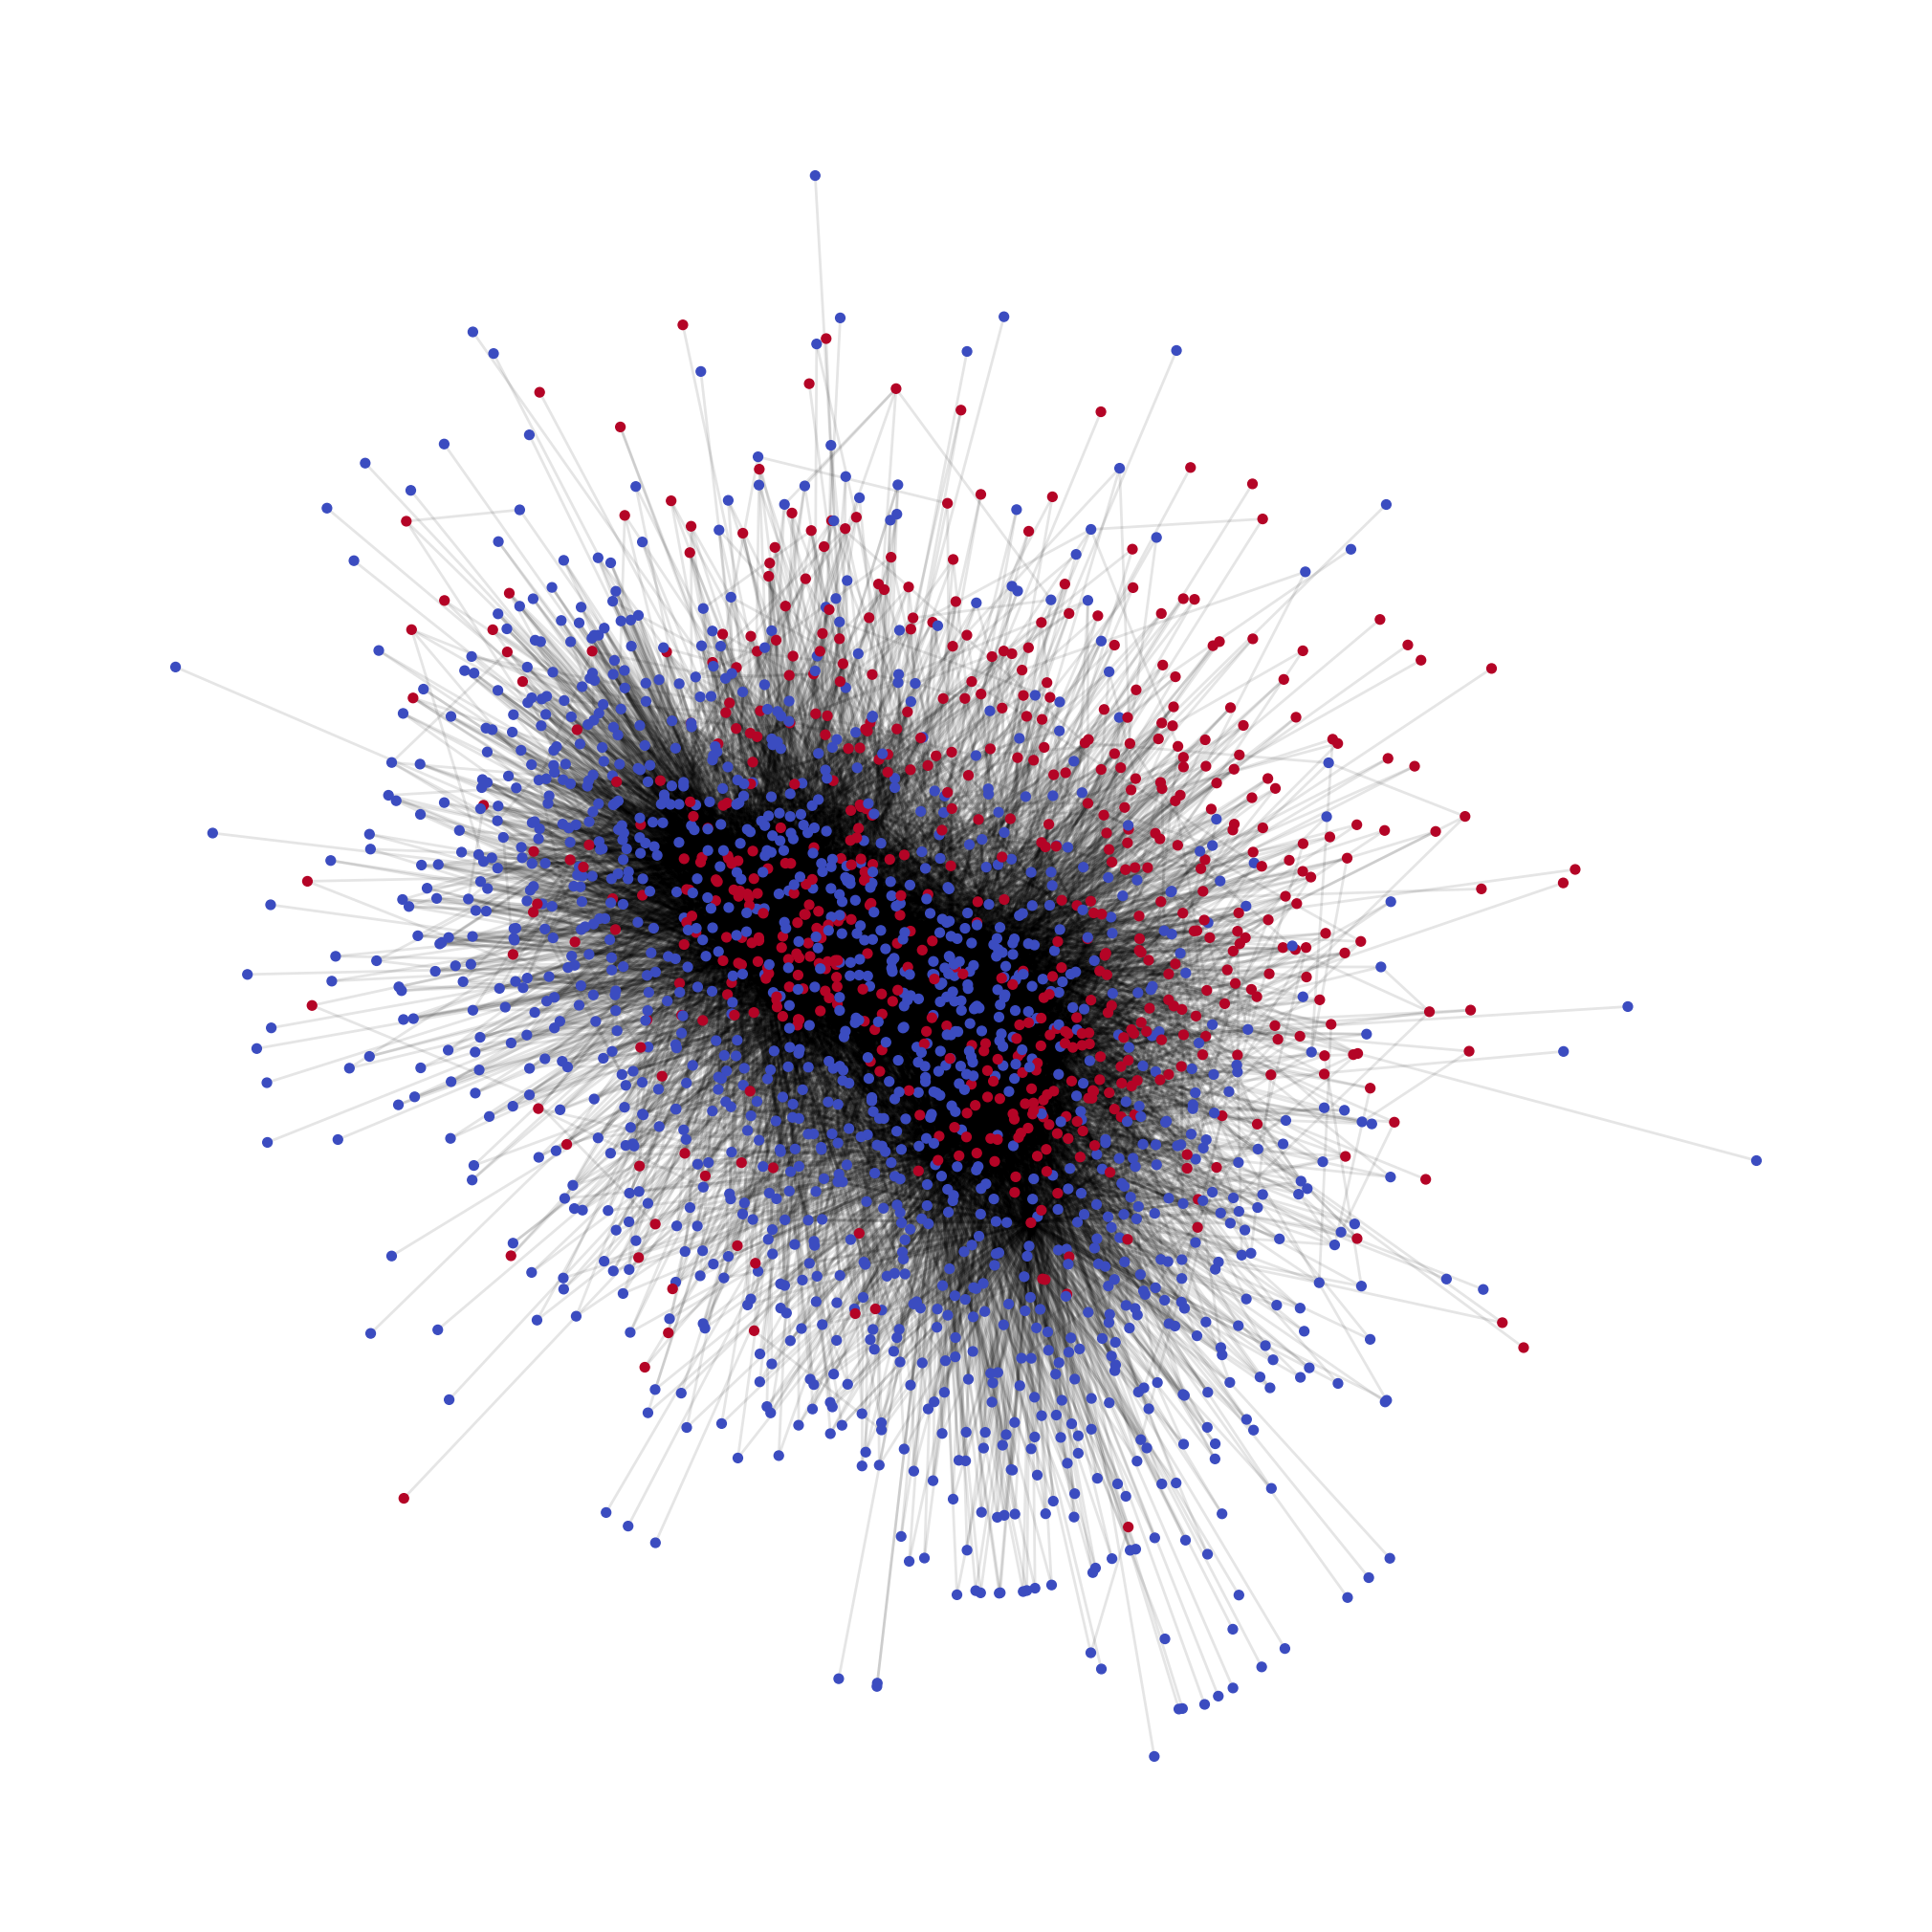

In [649]:
import matplotlib.pyplot as plt

# graph the large subgraph
color_map = {"user": 0, "movies": 1}
node_color = [color_map[attr['node_type']] for (id, attr) in sub_G_lg.nodes(data=True)]
plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

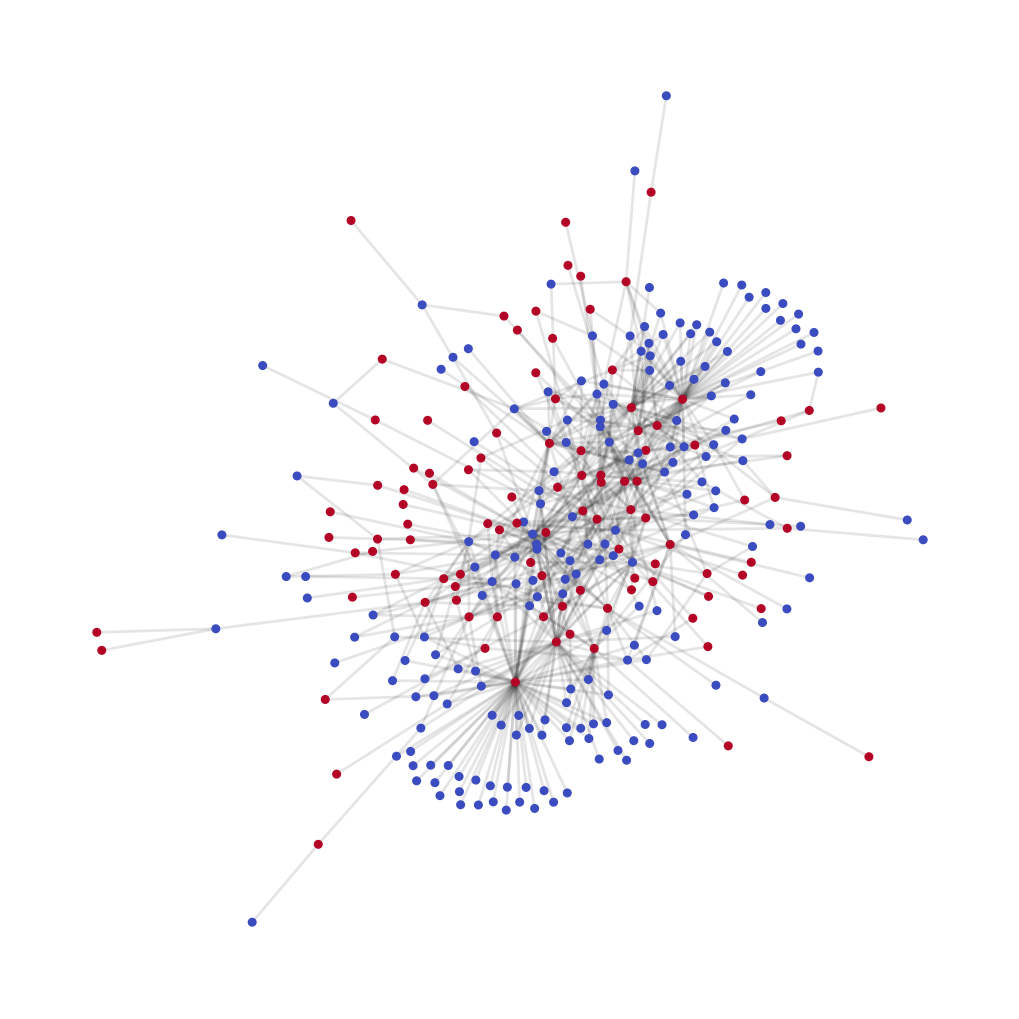

In [650]:
# Graph the subgraph of the small subgraph
color_map = {"user": 0, "movies": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

In [ ]:
# Show the smaller subgraph as bipartite
top = nx.bipartite.sets(sub_G_sm)[0]
pos = nx.bipartite_layout(sub_G_sm, top)
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))

------- end of plotting stuff -------

In [114]:
MovielensGraph.nodes()

NodeView(('user_2220', 'movie_3317', 'user_4313', 'user_4504', 'movie_3525', 'user_4304', 'movie_50794', 'user_5880', 'user_5361', 'user_7531', 'user_1834', 'user_4318', 'movie_2353', 'movie_3135', 'user_765', 'user_7891', 'movie_68954', 'movie_1303', 'user_5164', 'movie_2360', 'user_7288', 'user_1025', 'user_6566', 'user_9957', 'movie_943', 'movie_86142', 'movie_1447', 'user_1765', 'movie_3173', 'movie_709', 'user_6887', 'user_1507', 'movie_40732', 'movie_454', 'user_1392', 'user_6123', 'user_4880', 'user_4941', 'movie_5791', 'user_9874', 'user_2756', 'user_6208', 'user_2988', 'movie_8019', 'user_6534', 'user_4543', 'user_7723', 'user_8391', 'user_705', 'user_8217', 'user_886', 'user_9251', 'user_3621', 'movie_89753', 'user_5506', 'user_8911', 'user_8864', 'user_7471', 'movie_26285', 'user_9703', 'user_9695', 'user_7222', 'user_5619', 'movie_342', 'movie_2908', 'movie_7757', 'movie_1835', 'movie_5054', 'movie_89904', 'movie_39414', 'movie_2150', 'user_6886', 'user_1840', 'user_7677', 

In [624]:
import numpy as np

n_nodes, n_edges = MovielensGraph.number_of_nodes(), MovielensGraph.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(MovielensGraph.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

MovielensGraph = nx.relabel_nodes(MovielensGraph, node2id)

In [351]:
sorted_nodes

['movie_1',
 'movie_10',
 'movie_100',
 'movie_100163',
 'movie_100302',
 'movie_100383',
 'movie_100390',
 'movie_1005',
 'movie_100527',
 'movie_100556',
 'movie_1007',
 'movie_100714',
 'movie_1009',
 'movie_101',
 'movie_1010',
 'movie_101088',
 'movie_1011',
 'movie_101112',
 'movie_101142',
 'movie_1012',
 'movie_101285',
 'movie_1013',
 'movie_101360',
 'movie_101362',
 'movie_1014',
 'movie_1015',
 'movie_101525',
 'movie_101577',
 'movie_1016',
 'movie_1017',
 'movie_101739',
 'movie_101741',
 'movie_1018',
 'movie_101864',
 'movie_101895',
 'movie_1019',
 'movie_101962',
 'movie_101973',
 'movie_1020',
 'movie_102033',
 'movie_1021',
 'movie_102123',
 'movie_102125',
 'movie_102194',
 'movie_1022',
 'movie_1023',
 'movie_1024',
 'movie_102407',
 'movie_102445',
 'movie_102481',
 'movie_1025',
 'movie_102666',
 'movie_102686',
 'movie_1027',
 'movie_102716',
 'movie_102720',
 'movie_102753',
 'movie_1028',
 'movie_102800',
 'movie_1029',
 'movie_102903',
 'movie_102993',
 'mov

In [352]:
nx.get_node_attributes(MovielensGraph, 'name')

{8887: 'user_39410',
 8625: 'user_37485',
 13827: 'user_75710',
 6201: 'user_19485',
 6678: 'user_23120',
 16054: 'user_91715',
 8638: 'user_37575',
 115: 'movie_1050',
 1469: 'movie_2353',
 663: 'movie_1479',
 973: 'movie_1821',
 9420: 'user_43300',
 11301: 'user_56995',
 12639: 'user_66905',
 6623: 'user_22750',
 4770: 'user_100155',
 1685: 'movie_2641',
 10945: 'user_54450',
 11747: 'user_60290',
 3594: 'movie_60753',
 2195: 'movie_3334',
 14969: 'user_83900',
 516: 'movie_134130',
 12871: 'user_68720',
 12503: 'user_65915',
 15753: 'user_89475',
 2185: 'movie_3316',
 11854: 'user_61130',
 5418: 'user_13880',
 6648: 'user_22930',
 13085: 'user_70330',
 10699: 'user_52685',
 5138: 'user_11920',
 14662: 'user_81820',
 1702: 'movie_26662',
 638: 'movie_143367',
 6061: 'user_1845',
 4361: 'movie_8373',
 965: 'movie_1801',
 8093: 'user_33555',
 11471: 'user_58295',
 16383: 'user_94140',
 9617: 'user_44790',
 1557: 'movie_2471',
 6731: 'user_23530',
 10112: 'user_48335',
 12441: 'user_655

In [625]:
if "user_200952" in nx.get_node_attributes(MovielensGraph, 'name').values():
    print("yes") # double-checking again just to make sure

yes


In [626]:
# keep track of how many users / movies we have and make the lists torch-compatible
users_idx = [i for i, v in enumerate(node2id.keys()) if "user" in v]
movies_idx = [i for i, v in enumerate(node2id.keys()) if "movie" in v]

n_users = len(users_idx)
n_movies = len(movies_idx)

users_idx = torch.Tensor(users_idx).type(torch.int64)
movies_idx =torch.Tensor(movies_idx).type(torch.int64)

n_users, n_movies

(16500, 7666)

In [355]:
# Import relevant ML libraries # TODO move to the top
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss
from torch_geometric.utils import negative_sampling

from torch_geometric.nn.conv import LGConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.2.2; Torch-cuda version: None; Torch Geometric version: 2.5.2.


In [627]:
num_nodes = n_users +  n_movies
edge_idx = torch.Tensor(np.array(MovielensGraph.edges()).T).type(torch.int64)
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15,
    num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)


In [584]:
np.array(MovielensGraph.edges()).T

array([[13796, 13796, 13796, ..., 12571,  2932,  9045],
       [ 1024,  1511,  1854, ...,  5678,  8864,  5678]])

In [358]:
graph_data

Data(edge_index=[2, 1373530], num_nodes=17184)

Building GNN Model

In [404]:
class RecommendationGCN(torch.nn.Module):
    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        conv_layer = "LGC",
        name = None,
    ):
        super().__init__()
        # define hyperparameters
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(num_nodes, embedding_dim)

        self.alpha = 1. / (num_layers + 1) #this is the multiplicative factor that is used for summing layer embeddings

        # define layers (number of them will depend on hyperparameters)
        self.conv_layers = ModuleList (
            [ LGConv() for _ in range(num_layers) ]
        )
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for layer in self.conv_layers:
            layer.reset_parameters()


    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        out = x 

        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            out = out + (x * self.alpha)

        return out


    def get_pred_only(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        user_embeddings = embed[edge_label_index[0]]
        movie_embeddings = embed[edge_label_index[1]]
        return (user_embeddings * movie_embeddings).sum(dim=-1)
    

    # I liked the idea that the authors had to make this part of the model class
    # in order to access the embedding weights more easily.
    def recommendation_loss(
        self,
        loss_fn,
        pos_edge_rank: Tensor,
        neg_edge_rank: Tensor,
    ) -> Tensor:
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)


In [405]:
# BPRLoss NOTE this method was taken directly from https://medium.com/stanford-cs224w/spotify-track-neural-recommender-system-51d266e31e16 
class BPRLoss(_Loss):
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0):
        super().__init__(None, None, "sum")
        self.lambda_reg = lambda_reg

    def forward(
        self,
        positives: Tensor,
        negatives: Tensor,
        parameters: Tensor = None
    ) -> Tensor:

        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

In [406]:
# Train
def train(train_data, val_data, model, optimizer, args, name=""):
  stats = {
      'train': {
        'loss': [],
      },
      'val': {
        'loss': [],
      }
  }
  for epoch in range(args["epochs"]):
    model.train()
    optimizer.zero_grad()

    # STEP ONE: perform negative sampling
    neg_edge_index = negative_sampling(train_data.edge_label_index, num_nodes=(n_users, n_movies))
    neg_edge_label = torch.zeros(neg_edge_index.shape[1])

    # STEP TW0: get model embedding
    embed = model.get_embedding(train_data.edge_index)
    
    # STEP THREE: get predictions for positive and negative edges 
    # using the embedding obtained above
    pos_predictions = model.get_pred_only(embed, train_data.edge_label_index)
    neg_predictions = model.get_pred_only(embed, neg_edge_index)

    # STEP FOUR: loss calculations
    # BPRLoss
    lambda_reg = 1e-4  # loss regularization constant
    loss_fn = BPRLoss(lambda_reg)
    loss = model.recommendation_loss(loss_fn, pos_predictions, neg_predictions)

    loss.backward()
    optimizer.step()

    val_loss, val_neg_edge, val_neg_label = test(
        model, val_data, neg_edge_index=None, neg_edge_label=None
    )

    stats['train']['loss'].append(loss)
    stats['val']['loss'].append(val_loss)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}")

  pickle.dump(stats, open(f"model_stats/LightGCN{name}.pkl", "wb"))
  return stats


In [407]:
# Test
def test(model, val_data, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad():
    # STEP ONE: perform negative sampling
    neg_edge_index = negative_sampling(val_data.edge_label_index, num_nodes=(n_users, n_movies))
    neg_edge_label = torch.zeros(neg_edge_index.shape[1])
    # STEP TW0: get model embedding
    embed = model.get_embedding(val_data.edge_index)

    # STEP THREE: get predictions for positive and negative edges 
    # using the embedding obtained above
    pos_predictions = model.get_pred_only(embed, val_data.edge_label_index)
    neg_predictions = model.get_pred_only(embed, neg_edge_index)
    
    # STEP FOUR: loss calculations
    # BPRLoss
    lambda_reg = 1e-4  # loss regularization constant
    loss_fn = BPRLoss(lambda_reg)
    loss = model.recommendation_loss(loss_fn, pos_predictions, neg_predictions)

    # ROC Score
    # concatenate the predictions into one tensor for computing ROC
    predictions = torch.cat((pos_predictions, neg_predictions), dim=0)
    labels = torch.cat((val_data.edge_label, neg_edge_label), dim=0)
    roc = roc_auc_score(
      labels.flatten().numpy(),
      predictions.flatten().data.numpy()
    )

  return loss, roc, neg_edge_index, neg_edge_label

In [628]:
# initialize model and and optimizer
hyperparams = {
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 300
}
model = RecommendationGCN(
    num_nodes = num_nodes,
    num_layers = hyperparams['num_layers'],
    embedding_dim = hyperparams["emb_size"]
)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])

In [364]:
model.alpha

0.25

In [651]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [409]:
# create directory to save model_stats
if not os.path.exists("model_stats"):
  os.makedirs("model_stats")

In [367]:
train_split

Data(edge_index=[2, 963436], num_nodes=17184, edge_label=[481718], edge_label_index=[2, 481718])

In [629]:
train(train_split, val_split, model, optimizer, hyperparams, name="top-20k-implicit")

Epoch 0; Train loss 0.6931394934654236; Val loss 0.6927411556243896; Train ROC 0.5067807677318114; Val ROC 0.8125373934299496
Epoch 1; Train loss 0.6926693916320801; Val loss 0.6866006255149841; Train ROC 0.8590389100320326; Val ROC 0.9205928510392278
Epoch 2; Train loss 0.6864755153656006; Val loss 0.670642077922821; Train ROC 0.9248325544523958; Val ROC 0.9136462795793674
Epoch 3; Train loss 0.6704028844833374; Val loss 0.6427001953125; Train ROC 0.9171700211855054; Val ROC 0.910344861246751
Epoch 4; Train loss 0.6423060297966003; Val loss 0.6028740406036377; Train ROC 0.9131403723471995; Val ROC 0.9081412554484394
Epoch 5; Train loss 0.6023186445236206; Val loss 0.5531478524208069; Train ROC 0.9107339411851577; Val ROC 0.9069606661473457
Epoch 6; Train loss 0.5520452260971069; Val loss 0.49661731719970703; Train ROC 0.9098284395405523; Val ROC 0.9063054866778237
Epoch 7; Train loss 0.49512892961502075; Val loss 0.438586562871933; Train ROC 0.9093970139651057; Val ROC 0.9062501413286

{'train': {'loss': [tensor(0.6931, grad_fn=<DivBackward0>),
   tensor(0.6927, grad_fn=<DivBackward0>),
   tensor(0.6865, grad_fn=<DivBackward0>),
   tensor(0.6704, grad_fn=<DivBackward0>),
   tensor(0.6423, grad_fn=<DivBackward0>),
   tensor(0.6023, grad_fn=<DivBackward0>),
   tensor(0.5520, grad_fn=<DivBackward0>),
   tensor(0.4951, grad_fn=<DivBackward0>),
   tensor(0.4368, grad_fn=<DivBackward0>),
   tensor(0.3817, grad_fn=<DivBackward0>),
   tensor(0.3334, grad_fn=<DivBackward0>),
   tensor(0.2956, grad_fn=<DivBackward0>),
   tensor(0.2659, grad_fn=<DivBackward0>),
   tensor(0.2450, grad_fn=<DivBackward0>),
   tensor(0.2296, grad_fn=<DivBackward0>),
   tensor(0.2197, grad_fn=<DivBackward0>),
   tensor(0.2124, grad_fn=<DivBackward0>),
   tensor(0.2071, grad_fn=<DivBackward0>),
   tensor(0.2028, grad_fn=<DivBackward0>),
   tensor(0.1997, grad_fn=<DivBackward0>),
   tensor(0.1960, grad_fn=<DivBackward0>),
   tensor(0.1922, grad_fn=<DivBackward0>),
   tensor(0.1914, grad_fn=<DivBackwar

### Generating Predictions For My User

In [630]:
# get my user ID as it pertains to nodes in the graph
my_user_id = node2id["user_200952"]

In [632]:
my_user_obj = None
for obj in users:
    if obj.name == "user_200952":
        my_user_obj = obj
        break

In [482]:
test_split

Data(edge_index=[2, 1169884], num_nodes=17184, edge_label=[103224], edge_label_index=[2, 103224])

In [253]:
MovielensGraph

In [633]:
from torch_geometric.utils.convert import to_networkx
def get_subgraph_for_user(graph, user_id):
    # get all the edges associated with this user id
    graph_nx = to_networkx(test_split)
    user_edges = graph_nx.edges(user_id)
    # create a subgraph out of the edges that we just extracted
    user_subgraph = graph_nx.edge_subgraph(user_edges)
    return user_subgraph

user_subgraph = get_subgraph_for_user(test_split, my_user_id)
user_edge_idx = torch.Tensor(np.array(user_subgraph.edges()).T).type(torch.int64)
user_edge_idx

tensor([[16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857,
         16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857,
         16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857,
         16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857, 16857,
         16857, 16857],
        [ 1749,   418,  6255,  6924,  5666,  6602,  2854,  6344,  2663,  3000,
          1299,  6601,  1197,  7247,  6057,  4022,  3592,  4355,  3414,   295,
          1165,  6256,   416,  5698,  3379,  1806,  1612,   101,  1201,  2921,
          6891,  1786,   480,  5191,   135,  7410,  3394,   255,  6910,  5763,
          1844,    87]])

In [634]:
movies_for_validation = user_edge_idx[1].tolist()
movies_for_validation = [id2node[m] for m in movies_for_validation]

In [591]:
my_user_obj.ratings = dict(sorted(temp.items(), key=lambda item: item[1], reverse=True))
my_user_obj.ratings

{'movie_318': 1.0,
 'movie_356': 1.0,
 'movie_2953': 1.0,
 'movie_49286': 1.0,
 'movie_60397': 1.0,
 'movie_62999': 1.0,
 'movie_80549': 1.0,
 'movie_88163': 1.0,
 'movie_91529': 1.0,
 'movie_115617': 1.0,
 'movie_164179': 1.0,
 'movie_200332': 1.0,
 'movie_39': 0.9,
 'movie_111': 0.9,
 'movie_586': 0.9,
 'movie_4447': 0.9,
 'movie_6619': 0.9,
 'movie_33493': 0.9,
 'movie_40629': 0.9,
 'movie_40815': 0.9,
 'movie_45720': 0.9,
 'movie_52975': 0.9,
 'movie_58559': 0.9,
 'movie_72641': 0.9,
 'movie_76093': 0.9,
 'movie_80463': 0.9,
 'movie_106487': 0.9,
 'movie_109487': 0.9,
 'movie_113275': 0.9,
 'movie_187595': 0.9,
 'movie_500': 0.8,
 'movie_541': 0.8,
 'movie_1210': 0.8,
 'movie_4823': 0.8,
 'movie_5377': 0.8,
 'movie_5995': 0.8,
 'movie_6155': 0.8,
 'movie_33615': 0.8,
 'movie_33794': 0.8,
 'movie_44193': 0.8,
 'movie_56176': 0.8,
 'movie_56367': 0.8,
 'movie_66203': 0.8,
 'movie_79132': 0.8,
 'movie_80166': 0.8,
 'movie_91500': 0.8,
 'movie_96588': 0.8,
 'movie_96821': 0.8,
 'movie_

In [635]:
filename = "results/my_user.qrels"
sorted_movies = sorted(movies_for_validation, key=lambda m: my_user_obj.ratings[m], reverse=True)
with open(filename, 'w', newline='') as results_file:
    for m in sorted_movies:
        user = 200952
        movieID = m.split("movie_")[1]
        score = my_user_obj.ratings[m]

        results_file.write(f"{user} 0 {movieID} {score}\n")

In [79]:
# get the embedding of all users and items using the model we just trained
embeddings = model.get_embedding(graph_data.edge_index) #should be the full dataset
# get my predictions
predicted_ratings = model.get_pred_only(embeddings, user_edge_idx)

# grab the top 10 recommendations for comparison purposes
k = 10
top_items_indices = torch.argsort(predicted_ratings, descending=True)[:k]
top_recommended_movies = top_items_indices.tolist()
top_recommended_movies

[83, 20, 7, 90, 5, 6, 27, 4, 74, 65]

In [98]:
print(train_split)
print(graph_data)
print(f"num users: {n_users}, num movies: {n_movies}")

Data(edge_index=[2, 2063378], num_nodes=24329, edge_label=[1031689], edge_label_index=[2, 1031689])
Data(edge_index=[2, 2928326], num_nodes=24329)
num users: 16489, num movies: 7840


In [636]:
# get the embedding of all users and items using the model we just trained
embeddings = model.get_embedding(graph_data.edge_index) #should be the full dataset
embeddings.shape #this should only be for movies?

torch.Size([24166, 64])

In [637]:
movie_embeddings = embeddings[:n_movies]
movie_embeddings.shape

torch.Size([7666, 64])

In [638]:
user_embeddings = embeddings[my_user_id]
user_embeddings = torch.unsqueeze(user_embeddings, 0)
user_embeddings.shape

torch.Size([1, 64])

In [639]:
predicted_ratings = torch.sigmoid(torch.matmul(user_embeddings, movie_embeddings.t()))
predicted_ratings.shape

torch.Size([1, 7666])

In [597]:
predicted_ratings

tensor([[0.9967, 0.9332, 0.4880,  ..., 0.5798, 0.5673, 0.6284]],
       grad_fn=<SigmoidBackward0>)

In [640]:
# this was taken from https://medium.com/stanford-cs224w/lightgcn-for-movie-recommendation-eb6d112f1e8
scores, top_movie_indices = torch.sort(predicted_ratings, descending=True)
movie_indices = top_movie_indices.squeeze().tolist()
scores = scores.squeeze().tolist()
movie_indices

[2455,
 3225,
 3002,
 6832,
 6460,
 5558,
 5631,
 4855,
 3003,
 2499,
 4226,
 3603,
 5610,
 4160,
 5999,
 5678,
 480,
 483,
 2910,
 7130,
 5077,
 255,
 6602,
 4758,
 5908,
 4864,
 7329,
 505,
 6210,
 6230,
 2773,
 592,
 7648,
 4858,
 4590,
 4835,
 5612,
 6554,
 4328,
 4727,
 2195,
 6640,
 5196,
 712,
 3796,
 3191,
 3414,
 271,
 1231,
 7421,
 3592,
 7042,
 6647,
 636,
 5147,
 5579,
 1812,
 5871,
 416,
 7340,
 240,
 4766,
 482,
 204,
 4793,
 1033,
 340,
 4944,
 1299,
 556,
 510,
 5209,
 0,
 360,
 535,
 3978,
 478,
 5398,
 5191,
 4713,
 6240,
 5901,
 4750,
 116,
 3652,
 5223,
 7273,
 5527,
 252,
 984,
 5005,
 6296,
 3299,
 526,
 6342,
 518,
 7242,
 4550,
 575,
 7164,
 5660,
 495,
 406,
 6785,
 5187,
 7036,
 486,
 330,
 5413,
 4035,
 1151,
 6560,
 6907,
 3963,
 331,
 6251,
 2191,
 313,
 6192,
 6974,
 4751,
 7177,
 6462,
 4749,
 7170,
 6719,
 5034,
 727,
 5885,
 4980,
 153,
 2966,
 7420,
 6179,
 5163,
 295,
 5953,
 5722,
 5686,
 1276,
 6773,
 1310,
 5228,
 6104,
 7640,
 6447,
 509,
 6452,
 

In [641]:
k = 50
top_recommended_movies = movie_indices[:k]

In [88]:
user_edge_idx.shape #this should only be for users?

torch.Size([2, 97])

In [80]:
predicted_ratings.shape # --> it recommends me 97 movies

torch.Size([97])

In [642]:
# the movie IDs that are returned are the IDs as they appear in the graph, which means I need to do a bit of post-processing:
# 1. get the actual movielens IDs using node2id
# 2. get the name of the movie from movies_df
# 3. display the recs

print(f"Recommended for my user:")
for i, movie in enumerate(top_recommended_movies):
    movielensID = id2node[movie]
    movielensID = movielensID.split("movie_")[1]
    movie = movies_df[movies_df['movieId'] == int(movielensID)].iloc[0]
    movie_name = movie['title']
    movie_year = movie['year']
    print(f"{i+1}. {movie_name} ({movie_year})")

Recommended for my user:
1. Matrix, The  (1999)
2. Shawshank Redemption, The  (1994)
3. Fight Club  (1999)
4. Inception  (2010)
5. Lord of the Rings: The Return of the King, The  (2003)
6. Dark Knight, The  (2008)
7. Lord of the Rings: The Two Towers, The  (2002)
8. Lord of the Rings: The Fellowship of the Ring, The  (2001)
9. Pulp Fiction  (1994)
10. Star Wars: Episode IV - A New Hope  (1977)
11. Shrek  (2001)
12. Gladiator  (2000)
13. Silence of the Lambs, The  (1991)
14. Memento  (2000)
15. Pirates of the Caribbean: The Curse of the Black Pearl  (2003)
16. WALL·E  (2008)
17. Star Wars: Episode V - The Empire Strikes Back  (1980)
18. Raiders of the Lost Ark  (1981)
19. American Beauty  (1999)
20. Godfather, The  (1972)
21. Schindler's List  (1993)
22. Interstellar  (2014)
23. Eternal Sunshine of the Spotless Mind  (2004)
24. Monsters, Inc.  (2001)
25. Finding Nemo  (2003)
26. Usual Suspects, The  (1995)
27. Incredibles, The  (2004)
28. Star Wars: Episode VI - Return of the Jedi  (198

Evaluation metrics

In [434]:
def write_qrels_to_file(file_name, scores, movies, userID, run):
    results = []
    with open( file_name, 'w', newline='' ) as results_file:
        for i, (score, movie) in enumerate(zip(scores, movies)):
            user_recs = {}
            user_recs['user'] = userID
            user_recs['Q0'] = 'Q0'
            user_recs['item'] = movie
            user_recs['rank'] = i
            user_recs['score'] = score
            user_recs['algorithm'] = run
            results.append(user_recs)
        
        writer = csv.DictWriter(results_file, fieldnames=['user', 'Q0', 'item', 'rank','score','algorithm'])
        writer.writerows(results)


In [644]:
import csv

# create directory to save model_stats
if not os.path.exists("results"):
  os.makedirs("results")

NAME_OF_RUN = "20k_explicit_nodes"
results_file_name = os.path.join("results", f"{NAME_OF_RUN}.csv")
write_qrels_to_file(results_file_name, scores, movie_indices, 200952, NAME_OF_RUN)

In [436]:
'''
    Code for NDCG --> citing my previous work in MSCI541 for the overall logic in this snippet
'''
def compute_NDCG(k: int, qrels: dict, results: dict, metrics: dict, algo_name: str, NUM_USERS: int = 1011):

    NDCGs = []
    for_avg = 0

    # compute average precision
    for userid, recommendations in results.items():
        curr_dcg = 0
        curr_idcg = 0

        k_actual = min(k, len(recommendations))
        # compute DCG
        for i in range(k_actual):
            movie = recommendations[i]
            gain = 0 if movie not in qrels[userid].keys() else qrels[userid][movie]
            
            rank = i + 1
            curr_dcg += gain / (math.log2(1+rank))

        # figure out ideal search rankings
        #   1. get number of documents that are relevant
        rel_bar = len(qrels[userid].values())
        #   2. mimic ideal search results
        k_ideal = min(k, rel_bar)

        rank = 1
        for ground_truth_rating in qrels[userid].values():
            curr_idcg += ground_truth_rating / (math.log2(1+rank))
            rank += 1
            if rank > k_ideal:
                break

        # compute NDCG = DCG / IDCG
        curr_NCDG = curr_dcg / curr_idcg
        NDCGs.append(f"{userid},{curr_NCDG}")

        for_avg += curr_NCDG

    avg_NDCG = for_avg/NUM_USERS
    metric_name = f"NDCG_at_{k}"
    metrics[metric_name][algo_name] = avg_NDCG
    print(f"avg NDCG@{k}: {'{:.3f}'.format(round(avg_NDCG,6))}")
    return NDCGs


In [437]:
def get_qrels(qrels_path: str) -> dict:
    '''utility reading in QRELS file and saving it as a dictionary'''

    qrels_all_users = {}

    with open(qrels_path, 'r') as f:
        for line in f:
            parts_of_line = line.split()  

            userid, movie, rating = parts_of_line[0], parts_of_line[2], parts_of_line[3]
            if userid not in qrels_all_users.keys():
                qrels_all_users[userid] = {}
            
            qrels_all_users[userid][movie] = float(rating)

    return qrels_all_users

In [438]:
def get_results(results_path: str) -> tuple[dict, str]:
    '''
        Utility for reading in RESULTS file and saving it as a dictionary.
        The format of the dictionary is userid: [movieid, movieid, movieid].
            The results files are all sorted in order of rankings, so appending the movie IDs to a list should preserve the order for purposes of judging rank later.
    '''

    results_all_users = {}

    with open(results_path, 'r') as f:
        for line in f:
            parts_of_line = line.split(",")

            userid, movie, score = parts_of_line[0], parts_of_line[2], parts_of_line[3]
            algorithm = parts_of_line[5]
            if userid not in results_all_users.keys():
                results_all_users[userid] = []

            results_all_users[userid].append(movie)

    return results_all_users, algorithm

In [645]:
qrels_for_me = get_qrels(qrels_path="results/my_user.qrels")
qrels_for_me

{'200952': {'2953': 1.0,
  '88163': 1.0,
  '356': 1.0,
  '60397': 1.0,
  '80549': 1.0,
  '40629': 0.9,
  '4447': 0.9,
  '111': 0.9,
  '33493': 0.9,
  '109487': 0.9,
  '5995': 0.8,
  '66203': 0.8,
  '33794': 0.8,
  '164909': 0.8,
  '116797': 0.8,
  '286897': 0.8,
  '80166': 0.8,
  '541': 0.8,
  '33615': 0.8,
  '6155': 0.8,
  '2': 0.7,
  '69406': 0.7,
  '80860': 0.7,
  '7361': 0.7,
  '2797': 0.7,
  '6942': 0.7,
  '912': 0.7,
  '204698': 0.7,
  '102903': 0.7,
  '70293': 0.6,
  '2694': 0.6,
  '1721': 0.6,
  '201646': 0.6,
  '1196': 0.6,
  '104211': 0.6,
  '116823': 0.5,
  '202439': 0.5,
  '166528': 0.4,
  '192803': 0.4,
  '166635': 0.4,
  '7360': 0.1,
  '103249': 0.1}}

In [646]:
results, name_of_algo = get_results(results_path=results_file_name)

metrics = {
    "NDCG_at_10": {},
    "NDCG_at_100": {},
    "NDCG_at_1000": {},
    f"NDCG_at_{n_movies}": {},
}

# compute NDCG @ 10 for me
NDCGs_at_10 = compute_NDCG(k=10, qrels=qrels_for_me, results=results, metrics=metrics, algo_name=name_of_algo, NUM_USERS=1)
# compute NDCG @ 100 for me
NDCGs_at_100 = compute_NDCG(k=100, qrels=qrels_for_me, results=results, metrics=metrics, algo_name=name_of_algo, NUM_USERS=1)
# compute NDCG @ 1000 for me
NDCGs_at_1000 = compute_NDCG(k=1000, qrels=qrels_for_me, results=results, metrics=metrics, algo_name=name_of_algo, NUM_USERS=1)
# compute NDCG @ 7840 for me
NDCGs_at_n_movies = compute_NDCG(k=n_movies, qrels=qrels_for_me, results=results, metrics=metrics, algo_name=name_of_algo, NUM_USERS=1)

avg NDCG@10: 0.000
avg NDCG@100: 0.000
avg NDCG@1000: 0.012
avg NDCG@7666: 0.118


In [302]:
import math